# Student Experiment: Cat vs. Dog Image Classification with CNN
## Overview

Objective: Students will learn image classification by building a Convolutional Neural Network (CNN) to distinguish between cats and dogs.

Environment: Google Colab (GPU recommended).
Libraries: Pillow, TensorFlow/Keras, NumPy, Matplotlib.


# step 0: Import Necessary Libraries

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

## Step 1: Generate and Visualize Synthetic Images

Task: Generate 100 synthetic images (50 cats, 50 dogs) using Pillow, visualize a few examples, and save them for later use. This step introduces students to synthetic data creation.

Student Tasks:

    Run the code to generate and visualize images.
    Check the generated images in dataset/synthetic/.
    Save images to Google Drive and verify the Drive folder.
    Discuss: How do synthetic cats and dogs differ from real ones? (Simple shapes vs. complex textures)

In [ ]:
! pip install pillow

Generating synthetic images...
Generated 50 cat and 50 dog images!


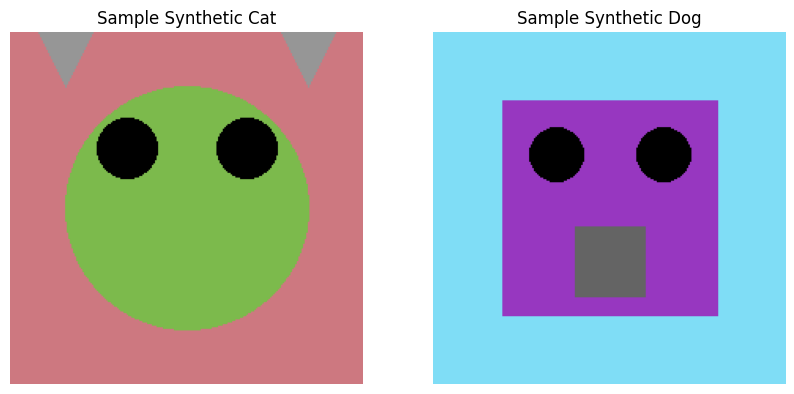

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Synthetic images saved to Google Drive!


In [ ]:
from PIL import Image, ImageDraw
import numpy as np
import os
import random
import matplotlib.pyplot as plt

# Create directories
os.makedirs('dataset/synthetic/cats', exist_ok=True)
os.makedirs('dataset/synthetic/dogs', exist_ok=True)

# Random background color
def random_background():
    return (random.randint(100, 255), random.randint(100, 255), random.randint(100, 255))

# Generate cat image (circular head, triangular ears, oval eyes)
def generate_cat_image(img_size=(224, 224), idx=0):
    img = Image.new('RGB', img_size, color=random_background())
    draw = ImageDraw.Draw(img)

    # Circular head
    head_size = random.randint(60, 80)
    head_center = (img_size[0]//2, img_size[1]//2)
    draw.ellipse(
        [head_center[0]-head_size, head_center[1]-head_size,
         head_center[0]+head_size, head_center[1]+head_size],
        fill=(random.randint(50, 200), random.randint(50, 200), random.randint(50, 200))
    )

    # Triangular ears
    ear_size = head_size // 2
    draw.polygon(
        [(head_center[0]-head_size, head_center[1]-head_size),
         (head_center[0]-head_size-ear_size, head_center[1]-head_size-ear_size*2),
         (head_center[0]-head_size+ear_size, head_center[1]-head_size-ear_size*2)],
        fill=(150, 150, 150)
    )
    draw.polygon(
        [(head_center[0]+head_size, head_center[1]-head_size),
         (head_center[0]+head_size+ear_size, head_center[1]-head_size-ear_size*2),
         (head_center[0]+head_size-ear_size, head_center[1]-head_size-ear_size*2)],
        fill=(150, 150, 150)
    )

    # Oval eyes
    eye_size = head_size // 4
    draw.ellipse(
        [head_center[0]-head_size//2-eye_size, head_center[1]-head_size//2-eye_size,
         head_center[0]-head_size//2+eye_size, head_center[1]-head_size//2+eye_size],
        fill=(0, 0, 0)
    )
    draw.ellipse(
        [head_center[0]+head_size//2-eye_size, head_center[1]-head_size//2-eye_size,
         head_center[0]+head_size//2+eye_size, head_center[1]-head_size//2+eye_size],
        fill=(0, 0, 0)
    )

    img.save(f'dataset/synthetic/cats/cat_{idx}.png')
    return img

# Generate dog image (rectangular head, square nose, circular eyes)
def generate_dog_image(img_size=(224, 224), idx=0):
    img = Image.new('RGB', img_size, color=random_background())
    draw = ImageDraw.Draw(img)

    # Rectangular head
    head_size = random.randint(60, 80)
    head_center = (img_size[0]//2, img_size[1]//2)
    draw.rectangle(
        [head_center[0]-head_size, head_center[1]-head_size,
         head_center[0]+head_size, head_center[1]+head_size],
        fill=(random.randint(50, 200), random.randint(50, 200), random.randint(50, 200))
    )

    # Square nose
    nose_size = head_size // 3
    draw.rectangle(
        [head_center[0]-nose_size, head_center[1]+head_size//2-nose_size,
         head_center[0]+nose_size, head_center[1]+head_size//2+nose_size],
        fill=(100, 100, 100)
    )

    # Circular eyes
    eye_size = head_size // 4
    draw.ellipse(
        [head_center[0]-head_size//2-eye_size, head_center[1]-head_size//2-eye_size,
         head_center[0]-head_size//2+eye_size, head_center[1]-head_size//2+eye_size],
        fill=(0, 0, 0)
    )
    draw.ellipse(
        [head_center[0]+head_size//2-eye_size, head_center[1]-head_size//2-eye_size,
         head_center[0]+head_size//2+eye_size, head_center[1]-head_size//2+eye_size],
        fill=(0, 0, 0)
    )

    img.save(f'dataset/synthetic/dogs/dog_{idx}.png')
    return img

# Generate 50 cats and 50 dogs
print("Generating synthetic images...")
cat_images, dog_images = [], []
for i in range(50):
    cat_images.append(generate_cat_image(idx=i))
    dog_images.append(generate_dog_image(idx=i))
print("Generated 50 cat and 50 dog images!")

# Visualize a few examples
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cat_images[0])
plt.title("Sample Synthetic Cat")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(dog_images[0])
plt.title("Sample Synthetic Dog")
plt.axis('off')
plt.show()

# Save to Google Drive
from google.colab import drive
drive.mount('/content/drive')
!cp -r dataset/synthetic /content/drive/MyDrive/synthetic_dataset
print("Synthetic images saved to Google Drive!")

Question: how is the cat and dog picture looks like?



> Don't worry too much, you will learn how to generate cats and dogs that are definitely more realistic than this! This is just to get a feel for it.



## Step 2: pre-processing

Step 2.1: Define Constants

    Define constants for image size (IMG_SIZE = (224, 224)) and batch size (BATCH_SIZE = 32) to standardize input dimensions and training batch processing.

In [ ]:
# Define image size and batch size

Step 2.2: Load and Preprocess the Real Dataset

    Write a function load_real_dataset() to load the cats_vs_dogs dataset from TensorFlow Datasets.
    Split the dataset into 80% training and 20% testing using split=['train[:80%]', 'train[80%:]'].
    Define a preprocessing function to resize images to IMG_SIZE and normalize pixel values to [0,1].
    Apply preprocessing, batching, and prefetching to optimize data loading.

In [ ]:
# 1. Load and preprocess the real dataset (Cats vs Dogs from TensorFlow Datasets)
def load_real_dataset():

    # Load dataset with splits for train and test


    # Preprocess function
    # Normalize to [0,1]
    # Apply preprocessing and batching

# 2. Load and preprocess the synthetic dataset
def load_synthetic_dataset():

    # Load dataset with splits for train and test


    # Preprocess function
    # Normalize to [0,1]
    # Apply preprocessing and batching

# step 3: cnn model

In [ ]:
# 3. Define CNN model
def create_cnn_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# step 4: Train and evaluate model with epoches 10

In [ ]:
# 4. Train and evaluate model
def train_and_evaluate(model, train_data, val_data, dataset_name, epochs=10):

    # Evaluate on validation set

    # Plot training history


    return history, val_accuracy

step 5:

In [ ]:
# 5. Main execution
if __name__ == "__main__":
    # Load datasets


    # Create and train model on real dataset

    # Create and train model on synthetic dataset

    # Compare performance

    # Visualize comparison using a bar chart


    # Save models to Google Drive, optional


Question: how is the results? what's the difference from real and synthetic dataset?